# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Batch-Normalization:-Exemplo-com-MNIST" data-toc-modified-id="Batch-Normalization:-Exemplo-com-MNIST-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Batch Normalization: Exemplo com MNIST</a></div><div class="lev2 toc-item"><a href="#Dataset-MNIST" data-toc-modified-id="Dataset-MNIST-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset MNIST</a></div><div class="lev2 toc-item"><a href="#Callback-especial" data-toc-modified-id="Callback-especial-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Callback especial</a></div><div class="lev2 toc-item"><a href="#Procedimentos-para-treino-e-teste" data-toc-modified-id="Procedimentos-para-treino-e-teste-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Procedimentos para treino e teste</a></div><div class="lev2 toc-item"><a href="#Parâmetros-globais" data-toc-modified-id="Parâmetros-globais-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Parâmetros globais</a></div><div class="lev2 toc-item"><a href="#Rede-neural-sem-batch-norm" data-toc-modified-id="Rede-neural-sem-batch-norm-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Rede neural sem batch-norm</a></div><div class="lev3 toc-item"><a href="#Treinamento" data-toc-modified-id="Treinamento-151"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Treinamento</a></div><div class="lev3 toc-item"><a href="#Testes" data-toc-modified-id="Testes-152"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Testes</a></div><div class="lev2 toc-item"><a href="#Rede-neural-com-batch-norm" data-toc-modified-id="Rede-neural-com-batch-norm-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Rede neural com batch-norm</a></div><div class="lev3 toc-item"><a href="#Treinamento" data-toc-modified-id="Treinamento-161"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Treinamento</a></div><div class="lev3 toc-item"><a href="#Testes" data-toc-modified-id="Testes-162"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Testes</a></div>

# Batch Normalization: Exemplo com MNIST

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import time
import numpy as np
import numpy.random as nr
import scipy
import argparse

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.datasets import mnist

from sklearn.utils import shuffle

print('Keras ', keras.__version__)
print('Numpy ', np.__version__)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models',exist_ok=True)

Using TensorFlow backend.


Keras  2.0.4
Numpy  1.12.1


In [2]:
import keras.backend as K

K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_first
Available GPUS: ['/gpu:0']


## Dataset MNIST

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Original dataset: ', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train, y_train = shuffle(X_train, y_train, random_state=20170528)
X_test, y_test = shuffle(X_test, y_test, random_state=20170527)

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

# one-hot encoding:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

n_samples_train = 60000
n_samples_test  = 10000

X_train = X_train[:n_samples_train]
y_train = y_train[:n_samples_train]
X_test = X_test[:n_samples_test]
y_test = y_test[:n_samples_test]

print('Effective dataset:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Original dataset:  (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Effective dataset: (60000, 1, 28, 28) (60000, 10) (10000, 1, 28, 28) (10000, 10)


## Callback especial

In [4]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
    

## Procedimentos para treino e teste

In [5]:
def train_network(model, model_name, Xtra=X_train, ytra=y_train, Xval=X_test, yval=y_test, 
                  opt='rmsprop', batch_size=60, nepochs=50000, patience=500, nr_seed=20170522, 
                  reset=False, ploss=1.0):
    
    nr.seed = nr_seed
    
    if reset and os.path.isfile(model_name + '.model'):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_name + '.model'):
        print("[INFO] creating model...")
        model = build_net()

        # History, checkpoint, earlystop, plot losses:
        my_cb = MyCb(n=1, filepath=model_name, patience=patience)

        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

    else:
        print("[INFO] loading model...")
        model, my_cb = load_model_and_history(model_name)

    past_epochs = my_cb.get_nepochs()
    tr_epochs = nepochs - past_epochs

    fig = plot.figure(figsize=(15,6))
    plot.ylim(0.0, ploss)
    plot.xlim(0, nepochs)
    plot.grid(True)

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[my_cb])
    except KeyboardInterrupt:
        pass

    return model

def test_network(model_name, Xtest=X_test, ytest=y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Parâmetros globais

In [6]:
params = {
    'opt':        SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'batch_size': 100, 
    'nepochs':    50, 
    'patience':   20,
    'nr_seed':    20170523,
    'ploss':      0.25,
    'reset':      True, 
}


## Rede neural sem batch-norm

In [7]:
model_name = '../../models/bnorm_mnist_conv_1'

def build_net(width=28, height=28, depth=1, classes=10):
    model = Sequential()

    model.add(Conv2D(20, (5, 5), padding="same", input_shape=(depth,height, width)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model


### Treinamento

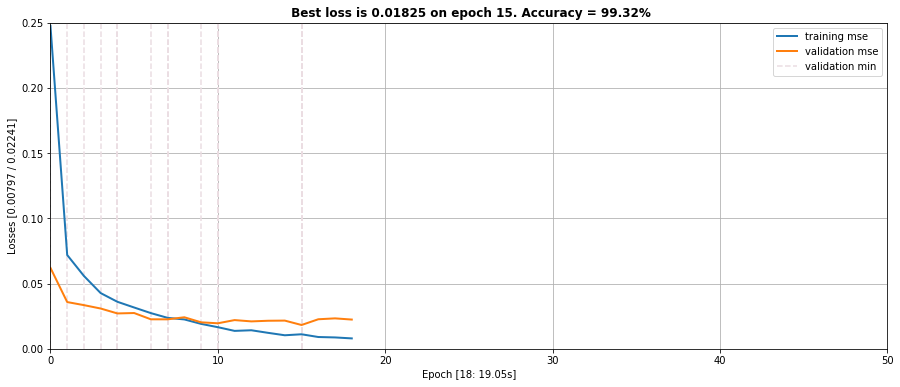

In [8]:
train_network(build_net, model_name, **params);

### Testes

In [9]:
test_network(model_name)

Model from epoch 15
[INFO] evaluating in the test data set ...
 9344/10000 [===========================>..] - ETA: 0s
[INFO] accuracy on the test data set: 99.32% [0.01825]


## Rede neural com batch-norm

In [10]:
model_name_bn = '../../models/bnorm_mnist_conv_bn_1'

def build_net_bn(width=28, height=28, depth=1, classes=10):
    # initialize the model
    model = Sequential()

    model.add(Conv2D(20, (5, 5), padding="same", input_shape=(depth, height, width)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(BatchNormalization(axis=1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500))
    model.add(BatchNormalization(axis=1))
    model.add(Activation("relu"))

    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model


### Treinamento

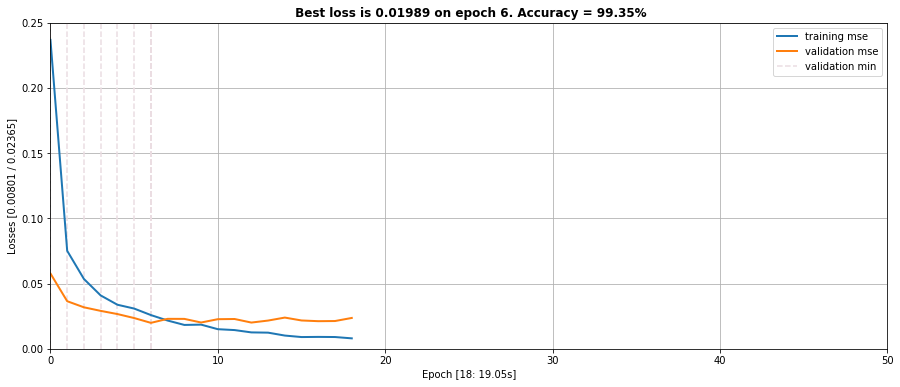

In [11]:
train_network(build_net_bn, model_name_bn, **params);

### Testes

In [12]:
test_network(model_name_bn)

Model from epoch 6
[INFO] evaluating in the test data set ...
 9344/10000 [===========================>..] - ETA: 0s
[INFO] accuracy on the test data set: 99.35% [0.01989]
